In [89]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm.auto import tqdm

import pygame

In [90]:
# brush properties
r = 5
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state


def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def print_something(something):
    fps = f'{something:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

def plot_classification_scores(class_scores, correct_classes, width=100, height=400):
    num_samples = class_scores.shape[0]
    BAR_WIDTH = width
    BAR_HEIGHT = int( 0.8 * height / (4 * num_samples))
    BAR_SPACING = BAR_HEIGHT // 2
    BAR_Y_OFFSET = int(0.1 * height)

    CLASS_SPACING = 3*BAR_HEIGHT

    # Create a surface for drawing the graph
    graph_surface = pygame.Surface((width, height), pygame.SRCALPHA)
    graph_surface.fill((255, 255, 255, 63))  # Fill with transparent color

    for i in range(num_samples):
        score1 = class_scores[i][0]
        score2 = class_scores[i][1]
        correct_class = correct_classes[i]

        # # Normalize scores to fit in the graph
        # score1 = max(min(score1, 1), -1)  # Clamp scores to be within [-1, 1]
        # score2 = max(min(score2, 1), -1)

        # Draw the bars
        predicted = np.argmax([score1, score2])
        bar_colors = np.zeros((2, 3))
        GREEN = np.array([0, 255, 0])
        RED = np.array([255, 0, 0])

        if predicted == correct_class:
            # Highlight the correct class
            bar_colors[predicted] = GREEN
        else:
            bar_colors[predicted] = RED

        # Draw left bar
        # rect(left, top, width, height)
        bar1_top = i * (2 * BAR_HEIGHT + CLASS_SPACING) + BAR_Y_OFFSET
        bar1_width = int(score1 * BAR_WIDTH)
        pygame.draw.rect(graph_surface, bar_colors[0], (0, bar1_top, bar1_width, BAR_HEIGHT))

        # Draw right bar
        # bar2_top = (i + 1) * BAR_HEIGHT + i * CLASS_SPACING + BAR_SPACING + BAR_Y_OFFSET
        bar2_top = bar1_top + BAR_HEIGHT + BAR_SPACING
        bar2_width = int(score2 * BAR_WIDTH)
        pygame.draw.rect(graph_surface, bar_colors[1], (0, bar2_top, bar2_width, BAR_HEIGHT))

        # Add text label
        text = font.render(f'N={i + 2}', True, (0, 0, 0))
        text_rect = text.get_rect(center=(width//2, int(bar1_top-0.5*BAR_Y_OFFSET)))
        graph_surface.blit(text, text_rect)

    return graph_surface

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), len(cdim_order))

    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

In [91]:
class Rule(nn.Module):
    def __init__(self,
                 CHANNELS=8,
                 FILTERS=1,
                 NET_SIZE=[16],
                 RES=50,
                 READIN_CHANNELS=1,
                 READOUT_CHANNELS=1,
                 READIN_SCALE=1,
                 READOUT_SCALE=1,
                 NUM_READOUT_HEADS=10):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.net_size = NET_SIZE
        # self.alpha = torch.nn.Parameter(torch.tensor([0.]))
        self.alpha = torch.nn.Parameter(torch.randn(CHANNELS))
        
        self.res = RES
        self.rin_channels = READIN_CHANNELS
        self.rout_channels = READOUT_CHANNELS
        self.rin_scale = READIN_SCALE
        self.rout_scale = READOUT_SCALE
        # total
        self.readin_res = int(READIN_SCALE*RES)
        self.readout_res = int(READOUT_SCALE*RES)

        # for forward_perception
        self.ident = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]).cuda()
        self.sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]).cuda() / 8.0
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).cuda() / 16.0

        self.filters = [nn.Parameter(0 * torch.randn(3, 3).cuda())
                        for i in range(FILTERS)]
        
        self.afunc = nn.LeakyReLU()
        self.ws = [torch.nn.Conv2d(CHANNELS * (4 + FILTERS), NET_SIZE[0], 1),
                   self.afunc]
        for i in range(len(NET_SIZE) - 1):
            self.ws.append(torch.nn.Conv2d(NET_SIZE[i], NET_SIZE[i + 1], 1))
            self.ws.append(self.afunc)
        self.ws += [torch.nn.Conv2d(NET_SIZE[-1], CHANNELS, 1)]
        self.ws = nn.Sequential(*self.ws)


        # self.w1 = torch.nn.Conv2d(CHANNELS * (4 + FILTERS), HIDDEN, 1)
        # self.w1.bias.data.zero_()
        # self.w2 = torch.nn.Conv2d(HIDDEN, HIDDEN, 1)
        # self.w3 = torch.nn.Conv2d(HIDDEN, CHANNELS, 1)

        # read in layer is used to project from 1D -> CA grid via 3 input channels
        # readout layer is used to project from CA grid via 3 output channels -> num_classes (2)
        
        self.readin = torch.nn.Linear(1, int(self.readin_res*self.readin_res*READIN_CHANNELS))
        self.readouts = nn.ModuleList([torch.nn.Linear(int(self.readout_res*self.readout_res*READOUT_CHANNELS), 2, bias=True).cuda() for i in range(NUM_READOUT_HEADS)])

        # self.module_list = torch.nn.ModuleList(self.ws + self.readouts)
        # self.module_dict = nn.ModuleDict({''})
        self.parameter_list = torch.nn.ParameterList(self.filters)
        # self.w2.weight.data.zero_()
        ###########################################

class CA(nn.Module):
    def __init__(self,
                 CHANNELS=8,
                 FILTERS=1,
                 NET_SIZE=[16],
                 RES=50,
                 READIN_CHANNELS=1,
                 READOUT_CHANNELS=1,
                 READIN_SCALE=1,
                 READOUT_SCALE=1,
                 NUM_READOUT_HEADS=10):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.net_size = NET_SIZE
        self.res = RES
        
        self.rule = Rule(
            CHANNELS=CHANNELS,
            FILTERS=FILTERS,
            NET_SIZE=NET_SIZE,
            RES=RES,
            READIN_CHANNELS=READIN_CHANNELS,
            READOUT_CHANNELS=READOUT_CHANNELS,
            READIN_SCALE=READIN_SCALE,
            READOUT_SCALE=READOUT_SCALE,
            NUM_READOUT_HEADS=NUM_READOUT_HEADS,
        )

    def initGrid(self, BS):
        grid = torch.cuda.FloatTensor(2 * np.random.rand(BS, self.channels, self.res, self.res) - 1)
        # first channel is input channel
        # grid[:, -1, ...] *= 0.
        return grid * 0.

    def seed(self, RES, n):
        seed = torch.randn(n, self.channels, RES, RES)
        return seed

    def perchannel_conv(self, x, filters):
        '''filters: [filter_n, h, w]'''
        b, ch, h, w = x.shape
        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:, None])
        return y.reshape(b, -1, h, w)

    def perception(self, x):
        filters = [self.rule.ident, self.rule.sobel_x, self.rule.sobel_x.T, self.rule.lap]
        filters = filters + self.rule.filters
        return self.perchannel_conv(x, torch.stack(filters))

    def get_living_mask(self, x, alive_thres=0):
        alpha_channel = x[:, 0:1, :, :]
        R = 1
        d = 2*R+1
        alpha_channel = F.pad(alpha_channel, (R, R, R, R), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=d, stride=1, padding=R).abs() > alive_thres
        alive_mask = alive_mask[:, :, R:-R, R:-R]

        return alive_mask

    def forward(self, x, dt=1, update_rate=1.):
        b, ch, h, w = x.shape
        pre_mask = self.get_living_mask(x)
        y = self.perception(x)
        y = self.rule.ws(y)
        # for layer_i in self.rule.ws[:-1]:
        #     y = F.leaky_relu(layer_i(y))
        #     # y = F.tanh(layer_i(y))
        # y = self.rule.ws[-1](y)
        # y = self.rule.w3(y)


        update_mask = (torch.rand(b, 1, h, w) + update_rate).floor().cuda()
        y = dt * y * update_mask
        y = y * pre_mask
        
        # y = dt * y
        # keep the first channel empty for inputs
        # y[:, -1, ...] *= 0.
        # res = torch.clamp(x + y, 0, 1)
        alpha = torch.sigmoid(self.rule.alpha).reshape(1, -1, 1, 1)
        res = (1 - alpha) * x + alpha * y
        post_mask = self.get_living_mask(res)
        res = res*post_mask
        # res = F.leaky_relu(x + y)
        return res

# Training

Let's train the model now in the N-Parity task. We will project the 1-D timeseries in 3 of the 8 channel dimensions of all the cells in the grid (size=1 x RESxRESx3). We will then read out from 3 different channels from the entire grid to get a classification (size=RESxRESx3 x 1).

In [92]:
def generate_binary_sequence(M):
    return (torch.rand(M) < 0.5) * 2. - 1.

def make_batch_Nbit_pair_parity(Ns, M, bs):
    with torch.no_grad():
        sequences = [generate_binary_sequence(M).unsqueeze(-1) for i in range(bs)]
        labels = [torch.stack([get_parity(s, N, DELAY_TIME) for s in sequences]) for N in Ns]

    return torch.stack(sequences), labels

def get_parity(vec, N, delta_t=0):
    # delta_t is a "thinking time", so if delta_t=2, then we calculate the parity with a 2 time_step shift
    start_time = len(vec) - N - delta_t
    end_time = start_time + N
    return  (((vec + 1)/2)[start_time:end_time].sum() % 2).long()

def pad_to(mat, shape_to):
    shape = mat.shape
    # shape diff
    shd = [shape_to[0]-shape[2], shape_to[1]-shape[3]]

    pad = [shd[0]//2, shd[0] - shd[0]//2, shd[1]//2, shd[1] - shd[1]//2]
    return F.pad(mat, pad, mode='constant')

In [93]:
criterion = nn.CrossEntropyLoss()

In [94]:
CHANNELS=9
FILTERS=0
NET_SIZE=[16]
NUM_READOUT_HEADS=100

READIN_CHANNELS = 1
READIN_SCALE = 0.5
READOUT_CHANNELS = 3
READOUT_SCALE = 0.25

DELAY_TIME = 0

RES = 12
BATCH_SIZE = 128

device = 'cuda'
ca = CA(CHANNELS=CHANNELS,
        FILTERS=FILTERS,
        NET_SIZE=NET_SIZE,
        RES=RES,
        READIN_CHANNELS=READIN_CHANNELS,
        READOUT_CHANNELS=READOUT_CHANNELS,
        READIN_SCALE=READIN_SCALE,
        READOUT_SCALE=READOUT_SCALE,
        NUM_READOUT_HEADS=NUM_READOUT_HEADS,
        ).to(device)

In [95]:
model_numel = 0
rout_numel = 0
for n, p in ca.named_parameters():
    print(f'{n:<20} {p.numel():>5}')
    if 'readouts' in n:
        rout_numel += p.numel()
    else:
        model_numel += p.numel()

print(f'{"# CA parameters:":<20} {model_numel:>5}')
print(f'{"# readout parameters:":<20} {rout_numel:>5}')
print(f'{"# total parameters:":<20} {model_numel + rout_numel:>5}')

rule.alpha               9
rule.ws.0.weight       576
rule.ws.0.bias          16
rule.ws.2.weight       144
rule.ws.2.bias           9
rule.readin.weight      36
rule.readin.bias        36
rule.readouts.0.weight    54
rule.readouts.0.bias     2
rule.readouts.1.weight    54
rule.readouts.1.bias     2
rule.readouts.2.weight    54
rule.readouts.2.bias     2
rule.readouts.3.weight    54
rule.readouts.3.bias     2
rule.readouts.4.weight    54
rule.readouts.4.bias     2
rule.readouts.5.weight    54
rule.readouts.5.bias     2
rule.readouts.6.weight    54
rule.readouts.6.bias     2
rule.readouts.7.weight    54
rule.readouts.7.bias     2
rule.readouts.8.weight    54
rule.readouts.8.bias     2
rule.readouts.9.weight    54
rule.readouts.9.bias     2
rule.readouts.10.weight    54
rule.readouts.10.bias     2
rule.readouts.11.weight    54
rule.readouts.11.bias     2
rule.readouts.12.weight    54
rule.readouts.12.bias     2
rule.readouts.13.weight    54
rule.readouts.13.bias     2
rule.readouts.14.we

In [96]:
def forward_pass(ca, sequences, num_readouts=1):
    ridx = np.random.choice(POOL.shape[0], BATCH_SIZE)
    state = POOL[ridx, ...].cuda()

    # for t in range(warmup_time):
    #     readin_patch = ca.rule.readin(torch.zeros(BATCH_SIZE, 1, 1).cuda()).reshape(BATCH_SIZE, READIN_CHANNELS, int(READIN_SCALE*RES), int(READIN_SCALE*RES))
    #     readin_patch = pad_to(readin_patch, (RES, RES))
    #     state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch
    #     state = ca(state)

    readin_res = int(READIN_SCALE*RES)
    for t in range(timesteps):
        readin_patch = ca.rule.readin(sequences[:, [t], 0]).reshape(BATCH_SIZE, READIN_CHANNELS, readin_res, readin_res)
        readin_patch = pad_to(readin_patch, (RES, RES))

        # readin_mask = pad_to(-torch.ones(1, READIN_CHANNELS, readin_res//2, readin_res//2), (RES, RES)).cuda() + 1
        # readin_mask = pad_to(-torch.ones(1, READIN_CHANNELS, int(readin_res//1.2), int(readin_res//1.2)), (RES, RES)).cuda() + 1
        # readin_patch = readin_patch * readin_mask
        
        state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch
        state = ca(state)

    if np.random.rand() > 0.5:
        POOL[ridx] = state.detach().cpu()
    else:
        POOL[ridx] = ca.seed(RES, BATCH_SIZE)

    readout_len = ca.rule.readout_res
    l_edge = RES//2 - int(readout_len/2)
    r_edge = l_edge + readout_len
    t_edge = RES//2 - int(readout_len/2)
    b_edge = t_edge + readout_len
    readout_patch = state[
                    :,
                    :READOUT_CHANNELS,
                    l_edge : r_edge,
                    t_edge : b_edge,
                    ]

    # readout_mask_res = readin_res * 2
    # mask = torch.ones((1, 1, RES, RES)).cuda() - pad_to(torch.ones((1, 1, readout_mask_res, readout_mask_res)).cuda(), (RES, RES))
    # readout_patch = (readout_patch * mask).reshape(BATCH_SIZE, -1)
    readout_patch = (readout_patch).reshape(BATCH_SIZE, -1)
    # readout_patch = F.max_pool2d(readout_patch, 2).reshape(BATCH_SIZE, -1)
    # print(f'patch_size: {readout_patch.shape}, weight_size: {ca.rule.readouts[0].weight.shape}')
    outs = [l_r(readout_patch) for l_r in ca.rule.readouts[:num_readouts]]


    return outs


In [97]:
num_epochs = 20
num_training_steps = 250
warmup_time = 0

POOL_SIZE = 1000
POOL = ca.seed(RES, POOL_SIZE)

p_group1 = [p for n, p in ca.rule.named_parameters() if 'readouts' not in n]
p_group2 = [p for n, p in ca.rule.named_parameters() if 'readouts' in n]

optim = torch.optim.Adam([
                {'params': p_group1},
                {'params': p_group2, 'weight_decay': 0.1}
            ], lr=1e-2, weight_decay=0.)
# optim = torch.optim.Adam(ca.parameters(), lr=1e-2, weight_decay=0)

# optim = torch.optim.SGD(ca.parameters(), lr=5e-3, momentum=0.1, nesterov=True)

# task details
# Ns = [2, 3]
Ns = list(np.arange(2, 8))
num_extra_heads = 1
k_factor = 1
min_T = 10 + (Ns[-1]) * k_factor + DELAY_TIME
max_T = 10 + min_T + 3*Ns[-1] * k_factor

loss_hist = []
accuracies = []
print('Training started...')
for i_epoch in tqdm(range(num_epochs)):
    for i in range(num_training_steps):
        optim.zero_grad()

        timesteps = np.random.randint(min_T, max_T)
        # np.random.randint(timesteps//5, timesteps//3)
        # thinking_time = np.random.randint(10, 30)

        sequences, labels = make_batch_Nbit_pair_parity(Ns, timesteps, BATCH_SIZE)
        sequences = sequences.to(device)
        sequences = sequences.repeat_interleave(k_factor, dim=1)
        timesteps = sequences.shape[1]
        labels = [l.to(device) for l in labels]

        outs = forward_pass(ca=ca, sequences=sequences, num_readouts=len(Ns))

        # Backward and optimize
        loss = 0.
        for N_i in range(len(Ns)):
            if N_i == len(Ns) - 1:
                discount = 0.1
            else:
                discount = 1.
            loss += discount * criterion(outs[N_i], labels[N_i])
        loss_hist.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(ca.parameters(), max_norm=2.0, norm_type=2)  # gradient clipping
        optim.step()

        # Test and measure accuracy
        correct_N = np.zeros_like(Ns)
        total = 0
        if (i + 1) % 25 == 0:
            with torch.no_grad():
                timesteps = np.random.randint(min_T, max_T)
                # warmup_time = 50
                # warmup_time = np.random.randint(timesteps//3, timesteps)
                # thinking_time = np.random.randint(10, 30)

                sequences, labels = make_batch_Nbit_pair_parity(Ns, timesteps, BATCH_SIZE)
                sequences = sequences.to(device)
                sequences = sequences.repeat_interleave(k_factor, dim=1)
                timesteps = sequences.shape[1]
                labels = [l.to(device) for l in labels]

                outs = forward_pass(ca=ca, sequences=sequences, num_readouts=len(Ns))
                
                loss_N = []
                for N_i in range(len(Ns)):
                    predicted = torch.max(outs[N_i], 1)[1]
                    loss_N.append(criterion(outs[N_i], labels[N_i]).item())

                    correct_N[N_i] += (predicted == labels[N_i]).sum()
                    total += labels[N_i].size(0)

            accuracy = 100 * correct_N / float(total) * len(Ns)
            accuracies.append(accuracy)

            print(f'Epoch: {i_epoch+1}/{num_epochs}, Step: {i+1}/{num_training_steps}, '
                  f'Loss: {loss_hist[-1]:.4f}, Accuracy: {np.mean(accuracy):.2f}')
            print('(N, accuracy, loss):\n' + ''.join([f'({Ns[i]}, {accuracy[i]:.4f}, {loss_N[i]:.4f})\n' for i in range(len(Ns))]), flush=True)
            
            

            if np.mean(accuracy[:-2]) > 98 or len(accuracy < 3):
                if accuracy[-2] > 98:
                    if len(Ns) == NUM_READOUT_HEADS:
                        break
                    print(f'Solved N = {Ns[-2]}, starting N = {Ns[-1]} + {num_extra_heads}')
                    Ns += [Ns[-1] + i for i in range(1, num_extra_heads+1)]
                    min_T = 10 + (Ns[-1]) * k_factor
                    max_T = 10 + min_T + 3*Ns[-1] * k_factor


Training started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Step: 25/250, Loss: 3.5223, Accuracy: 47.79
(N, accuracy, loss):
(2, 52.3438, 0.6891)
(3, 55.4688, 0.6906)
(4, 46.8750, 0.6948)
(5, 43.7500, 0.6944)
(6, 38.2812, 0.6993)
(7, 50.0000, 0.6934)
Epoch: 1/20, Step: 50/250, Loss: 2.8398, Accuracy: 62.11
(N, accuracy, loss):
(2, 100.0000, 0.0447)
(3, 67.1875, 0.6256)
(4, 57.8125, 0.6881)
(5, 51.5625, 0.6815)
(6, 42.9688, 0.6923)
(7, 53.1250, 0.6871)
Epoch: 1/20, Step: 75/250, Loss: 1.5582, Accuracy: 77.86
(N, accuracy, loss):
(2, 100.0000, 0.0072)
(3, 98.4375, 0.0287)
(4, 96.8750, 0.1433)
(5, 71.8750, 0.6087)
(6, 49.2188, 0.7141)
(7, 50.7812, 0.6957)
Epoch: 1/20, Step: 100/250, Loss: 0.4987, Accuracy: 92.71
(N, accuracy, loss):
(2, 100.0000, 0.0060)
(3, 100.0000, 0.0151)
(4, 100.0000, 0.0112)
(5, 99.2188, 0.0557)
(6, 93.7500, 0.2503)
(7, 63.2812, 0.6280)
Epoch: 1/20, Step: 125/250, Loss: 0.1984, Accuracy: 97.14
(N, accuracy, loss):
(2, 100.0000, 0.0022)
(3, 100.0000, 0.0071)
(4, 100.0000, 0.0118)
(5, 100.0000, 0.0294)
(6, 98.4375

  5%|▌         | 1/20 [00:35<11:05, 35.01s/it]

Epoch: 2/20, Step: 25/250, Loss: 0.2124, Accuracy: 96.79
(N, accuracy, loss):
(2, 100.0000, 0.0022)
(3, 100.0000, 0.0037)
(4, 100.0000, 0.0078)
(5, 100.0000, 0.0086)
(6, 100.0000, 0.0059)
(7, 100.0000, 0.0095)
(8, 99.2188, 0.0226)
(9, 100.0000, 0.0128)
(10, 71.8750, 0.5429)
Solved N = 9, starting N = 10 + 1
Epoch: 2/20, Step: 50/250, Loss: 0.2971, Accuracy: 97.19
(N, accuracy, loss):
(2, 100.0000, 0.0044)
(3, 100.0000, 0.0048)
(4, 100.0000, 0.0087)
(5, 100.0000, 0.0111)
(6, 100.0000, 0.0076)
(7, 100.0000, 0.0115)
(8, 100.0000, 0.0258)
(9, 100.0000, 0.0231)
(10, 92.1875, 0.1890)
(11, 79.6875, 0.4156)
Epoch: 2/20, Step: 75/250, Loss: 0.2113, Accuracy: 98.59
(N, accuracy, loss):
(2, 100.0000, 0.0059)
(3, 100.0000, 0.0042)
(4, 100.0000, 0.0051)
(5, 100.0000, 0.0071)
(6, 100.0000, 0.0120)
(7, 100.0000, 0.0095)
(8, 100.0000, 0.0112)
(9, 100.0000, 0.0124)
(10, 97.6562, 0.0697)
(11, 88.2812, 0.3410)
Epoch: 2/20, Step: 100/250, Loss: 0.1076, Accuracy: 99.30
(N, accuracy, loss):
(2, 100.0000, 0.

 10%|█         | 2/20 [01:26<13:29, 44.99s/it]

Epoch: 3/20, Step: 25/250, Loss: 0.4582, Accuracy: 97.32
(N, accuracy, loss):
(2, 100.0000, 0.0143)
(3, 100.0000, 0.0090)
(4, 100.0000, 0.0101)
(5, 100.0000, 0.0102)
(6, 100.0000, 0.0144)
(7, 100.0000, 0.0123)
(8, 100.0000, 0.0127)
(9, 100.0000, 0.0208)
(10, 100.0000, 0.0374)
(11, 98.4375, 0.0518)
(12, 100.0000, 0.0285)
(13, 100.0000, 0.0247)
(14, 94.5312, 0.1663)
(15, 69.5312, 0.5852)
Epoch: 3/20, Step: 50/250, Loss: 0.3369, Accuracy: 98.05
(N, accuracy, loss):
(2, 100.0000, 0.0063)
(3, 100.0000, 0.0044)
(4, 100.0000, 0.0049)
(5, 100.0000, 0.0096)
(6, 100.0000, 0.0092)
(7, 100.0000, 0.0068)
(8, 100.0000, 0.0121)
(9, 100.0000, 0.0107)
(10, 100.0000, 0.0164)
(11, 100.0000, 0.0250)
(12, 100.0000, 0.0171)
(13, 100.0000, 0.0173)
(14, 97.6562, 0.0934)
(15, 75.0000, 0.5579)
Epoch: 3/20, Step: 75/250, Loss: 0.3303, Accuracy: 97.77
(N, accuracy, loss):
(2, 100.0000, 0.0178)
(3, 100.0000, 0.0096)
(4, 100.0000, 0.0066)
(5, 100.0000, 0.0097)
(6, 100.0000, 0.0085)
(7, 100.0000, 0.0119)
(8, 100.000

 15%|█▌        | 3/20 [02:28<14:55, 52.69s/it]

Epoch: 4/20, Step: 25/250, Loss: 0.4446, Accuracy: 97.12
(N, accuracy, loss):
(2, 100.0000, 0.0127)
(3, 100.0000, 0.0150)
(4, 100.0000, 0.0065)
(5, 100.0000, 0.0151)
(6, 100.0000, 0.0113)
(7, 100.0000, 0.0083)
(8, 100.0000, 0.0193)
(9, 100.0000, 0.0116)
(10, 100.0000, 0.0211)
(11, 100.0000, 0.0234)
(12, 100.0000, 0.0121)
(13, 100.0000, 0.0170)
(14, 99.2188, 0.0409)
(15, 97.6562, 0.0919)
(16, 94.5312, 0.1897)
(17, 62.5000, 0.7093)
Epoch: 4/20, Step: 50/250, Loss: 0.3537, Accuracy: 97.66
(N, accuracy, loss):
(2, 100.0000, 0.0110)
(3, 100.0000, 0.0116)
(4, 100.0000, 0.0061)
(5, 100.0000, 0.0101)
(6, 100.0000, 0.0084)
(7, 100.0000, 0.0087)
(8, 100.0000, 0.0125)
(9, 100.0000, 0.0077)
(10, 99.2188, 0.0336)
(11, 100.0000, 0.0136)
(12, 99.2188, 0.0291)
(13, 100.0000, 0.0428)
(14, 99.2188, 0.0283)
(15, 100.0000, 0.0327)
(16, 97.6562, 0.0881)
(17, 67.1875, 0.5922)
Epoch: 4/20, Step: 75/250, Loss: 0.9185, Accuracy: 95.95
(N, accuracy, loss):
(2, 100.0000, 0.0095)
(3, 100.0000, 0.0082)
(4, 100.000

 20%|██        | 4/20 [03:36<15:36, 58.55s/it]

Solved N = 17, starting N = 18 + 1
Epoch: 5/20, Step: 25/250, Loss: 0.8946, Accuracy: 97.09
(N, accuracy, loss):
(2, 100.0000, 0.0280)
(3, 100.0000, 0.0208)
(4, 100.0000, 0.0123)
(5, 100.0000, 0.0230)
(6, 100.0000, 0.0098)
(7, 100.0000, 0.0129)
(8, 100.0000, 0.0175)
(9, 100.0000, 0.0164)
(10, 99.2188, 0.0297)
(11, 100.0000, 0.0303)
(12, 100.0000, 0.0138)
(13, 100.0000, 0.0398)
(14, 100.0000, 0.0222)
(15, 100.0000, 0.0172)
(16, 98.4375, 0.0859)
(17, 93.7500, 0.1305)
(18, 96.0938, 0.1290)
(19, 60.1562, 1.0215)
Epoch: 5/20, Step: 50/250, Loss: 0.6515, Accuracy: 97.35
(N, accuracy, loss):
(2, 100.0000, 0.0273)
(3, 100.0000, 0.0148)
(4, 100.0000, 0.0098)
(5, 100.0000, 0.0221)
(6, 100.0000, 0.0079)
(7, 100.0000, 0.0119)
(8, 100.0000, 0.0175)
(9, 100.0000, 0.0145)
(10, 99.2188, 0.0345)
(11, 100.0000, 0.0322)
(12, 98.4375, 0.0377)
(13, 100.0000, 0.0249)
(14, 100.0000, 0.0258)
(15, 100.0000, 0.0132)
(16, 96.8750, 0.1251)
(17, 100.0000, 0.0829)
(18, 96.0938, 0.1028)
(19, 61.7188, 0.6173)
Epoch: 

 25%|██▌       | 5/20 [04:51<16:10, 64.68s/it]

Epoch: 6/20, Step: 25/250, Loss: 0.5837, Accuracy: 97.33
(N, accuracy, loss):
(2, 100.0000, 0.0171)
(3, 100.0000, 0.0107)
(4, 100.0000, 0.0067)
(5, 100.0000, 0.0078)
(6, 100.0000, 0.0060)
(7, 100.0000, 0.0089)
(8, 100.0000, 0.0223)
(9, 100.0000, 0.0090)
(10, 100.0000, 0.0105)
(11, 100.0000, 0.0104)
(12, 100.0000, 0.0090)
(13, 100.0000, 0.0107)
(14, 100.0000, 0.0189)
(15, 100.0000, 0.0152)
(16, 100.0000, 0.0420)
(17, 97.6563, 0.0747)
(18, 100.0000, 0.0461)
(19, 97.6563, 0.0940)
(20, 53.9062, 0.6914)
Epoch: 6/20, Step: 50/250, Loss: 0.7187, Accuracy: 96.79
(N, accuracy, loss):
(2, 97.6563, 0.0699)
(3, 100.0000, 0.0211)
(4, 100.0000, 0.0046)
(5, 100.0000, 0.0086)
(6, 100.0000, 0.0061)
(7, 100.0000, 0.0133)
(8, 100.0000, 0.0120)
(9, 100.0000, 0.0094)
(10, 100.0000, 0.0168)
(11, 100.0000, 0.0171)
(12, 100.0000, 0.0175)
(13, 100.0000, 0.0312)
(14, 100.0000, 0.0138)
(15, 100.0000, 0.0110)
(16, 99.2188, 0.0627)
(17, 97.6563, 0.0516)
(18, 100.0000, 0.0403)
(19, 94.5312, 0.1382)
(20, 50.0000, 0.

 30%|███       | 6/20 [06:08<16:01, 68.69s/it]

Solved N = 20, starting N = 21 + 1
Epoch: 7/20, Step: 25/250, Loss: 1.1329, Accuracy: 95.65
(N, accuracy, loss):
(2, 99.2188, 0.0467)
(3, 99.2188, 0.0438)
(4, 100.0000, 0.0128)
(5, 100.0000, 0.0244)
(6, 100.0000, 0.0125)
(7, 99.2188, 0.0244)
(8, 98.4375, 0.0306)
(9, 100.0000, 0.0154)
(10, 100.0000, 0.0252)
(11, 99.2188, 0.0388)
(12, 100.0000, 0.0140)
(13, 96.8750, 0.0771)
(14, 100.0000, 0.0346)
(15, 99.2188, 0.0266)
(16, 98.4375, 0.0746)
(17, 99.2188, 0.0415)
(18, 99.2188, 0.0437)
(19, 93.7500, 0.1105)
(20, 99.2188, 0.1439)
(21, 79.6875, 0.4330)
(22, 47.6562, 0.8758)
Epoch: 7/20, Step: 50/250, Loss: 0.9835, Accuracy: 97.02
(N, accuracy, loss):
(2, 99.2188, 0.0301)
(3, 100.0000, 0.0141)
(4, 100.0000, 0.0053)
(5, 100.0000, 0.0232)
(6, 100.0000, 0.0086)
(7, 100.0000, 0.0081)
(8, 100.0000, 0.0182)
(9, 100.0000, 0.0099)
(10, 100.0000, 0.0134)
(11, 99.2188, 0.0260)
(12, 100.0000, 0.0210)
(13, 100.0000, 0.0228)
(14, 99.2188, 0.0249)
(15, 100.0000, 0.0160)
(16, 99.2188, 0.0416)
(17, 99.2188, 0

 35%|███▌      | 7/20 [07:31<15:55, 73.46s/it]

Solved N = 22, starting N = 23 + 1
Epoch: 8/20, Step: 25/250, Loss: 1.1735, Accuracy: 96.54
(N, accuracy, loss):
(2, 100.0000, 0.0188)
(3, 100.0000, 0.0199)
(4, 100.0000, 0.0281)
(5, 100.0000, 0.0189)
(6, 100.0000, 0.0166)
(7, 100.0000, 0.0202)
(8, 100.0000, 0.0214)
(9, 100.0000, 0.0208)
(10, 100.0000, 0.0268)
(11, 99.2188, 0.0395)
(12, 99.2188, 0.0286)
(13, 99.2188, 0.0320)
(14, 98.4375, 0.0431)
(15, 100.0000, 0.0080)
(16, 100.0000, 0.0317)
(17, 99.2188, 0.0382)
(18, 98.4375, 0.0467)
(19, 100.0000, 0.0277)
(20, 98.4375, 0.0853)
(21, 97.6562, 0.0592)
(22, 90.6250, 0.1839)
(23, 79.6875, 0.3735)
(24, 60.1562, 1.1811)
Epoch: 8/20, Step: 50/250, Loss: 0.9399, Accuracy: 97.55
(N, accuracy, loss):
(2, 97.6562, 0.0651)
(3, 100.0000, 0.0113)
(4, 100.0000, 0.0103)
(5, 100.0000, 0.0124)
(6, 100.0000, 0.0075)
(7, 100.0000, 0.0095)
(8, 100.0000, 0.0076)
(9, 100.0000, 0.0153)
(10, 100.0000, 0.0101)
(11, 100.0000, 0.0206)
(12, 100.0000, 0.0096)
(13, 99.2188, 0.0276)
(14, 100.0000, 0.0117)
(15, 100.0

 40%|████      | 8/20 [08:58<15:32, 77.69s/it]

Epoch: 9/20, Step: 25/250, Loss: 0.7877, Accuracy: 98.81
(N, accuracy, loss):
(2, 100.0000, 0.0149)
(3, 100.0000, 0.0043)
(4, 100.0000, 0.0125)
(5, 100.0000, 0.0134)
(6, 100.0000, 0.0120)
(7, 100.0000, 0.0152)
(8, 100.0000, 0.0111)
(9, 100.0000, 0.0129)
(10, 100.0000, 0.0165)
(11, 100.0000, 0.0156)
(12, 100.0000, 0.0102)
(13, 100.0000, 0.0115)
(14, 99.2188, 0.0196)
(15, 100.0000, 0.0155)
(16, 100.0000, 0.0134)
(17, 99.2188, 0.0322)
(18, 100.0000, 0.0238)
(19, 100.0000, 0.0273)
(20, 100.0000, 0.0248)
(21, 100.0000, 0.0320)
(22, 95.3125, 0.1035)
(23, 98.4375, 0.0804)
(24, 80.4688, 0.4254)
Solved N = 23, starting N = 24 + 1
Epoch: 9/20, Step: 50/250, Loss: 1.4551, Accuracy: 97.59
(N, accuracy, loss):
(2, 100.0000, 0.0293)
(3, 100.0000, 0.0203)
(4, 100.0000, 0.0169)
(5, 100.0000, 0.0182)
(6, 100.0000, 0.0146)
(7, 100.0000, 0.0094)
(8, 100.0000, 0.0075)
(9, 100.0000, 0.0159)
(10, 100.0000, 0.0116)
(11, 100.0000, 0.0200)
(12, 100.0000, 0.0189)
(13, 100.0000, 0.0176)
(14, 100.0000, 0.0164)
(1

 45%|████▌     | 9/20 [10:29<14:59, 81.74s/it]

Epoch: 10/20, Step: 25/250, Loss: 0.5855, Accuracy: 98.54
(N, accuracy, loss):
(2, 100.0000, 0.0039)
(3, 100.0000, 0.0063)
(4, 99.2188, 0.0137)
(5, 99.2188, 0.0235)
(6, 100.0000, 0.0070)
(7, 100.0000, 0.0179)
(8, 100.0000, 0.0043)
(9, 100.0000, 0.0072)
(10, 100.0000, 0.0129)
(11, 100.0000, 0.0097)
(12, 100.0000, 0.0076)
(13, 100.0000, 0.0096)
(14, 100.0000, 0.0051)
(15, 100.0000, 0.0190)
(16, 100.0000, 0.0190)
(17, 99.2188, 0.0400)
(18, 100.0000, 0.0218)
(19, 98.4375, 0.0549)
(20, 98.4375, 0.0513)
(21, 95.3125, 0.1035)
(22, 99.2188, 0.0652)
(23, 96.0938, 0.1014)
(24, 96.8750, 0.0937)
(25, 82.8125, 0.3918)
Epoch: 10/20, Step: 50/250, Loss: 0.7299, Accuracy: 98.47
(N, accuracy, loss):
(2, 98.4375, 0.0384)
(3, 100.0000, 0.0091)
(4, 96.0938, 0.0810)
(5, 100.0000, 0.0163)
(6, 100.0000, 0.0148)
(7, 100.0000, 0.0091)
(8, 100.0000, 0.0133)
(9, 100.0000, 0.0047)
(10, 100.0000, 0.0092)
(11, 99.2188, 0.0229)
(12, 100.0000, 0.0070)
(13, 100.0000, 0.0121)
(14, 100.0000, 0.0038)
(15, 98.4375, 0.0404

 50%|█████     | 10/20 [12:01<14:10, 85.06s/it]

Epoch: 11/20, Step: 25/250, Loss: 0.7269, Accuracy: 98.16
(N, accuracy, loss):
(2, 96.8750, 0.0595)
(3, 100.0000, 0.0119)
(4, 100.0000, 0.0091)
(5, 100.0000, 0.0184)
(6, 100.0000, 0.0135)
(7, 100.0000, 0.0134)
(8, 100.0000, 0.0211)
(9, 99.2188, 0.0240)
(10, 100.0000, 0.0239)
(11, 100.0000, 0.0135)
(12, 99.2188, 0.0310)
(13, 99.2188, 0.0182)
(14, 100.0000, 0.0089)
(15, 99.2188, 0.0349)
(16, 100.0000, 0.0169)
(17, 97.6562, 0.0458)
(18, 99.2188, 0.0172)
(19, 100.0000, 0.0094)
(20, 99.2188, 0.0234)
(21, 96.8750, 0.0772)
(22, 99.2188, 0.0369)
(23, 98.4375, 0.0500)
(24, 96.8750, 0.1184)
(25, 96.0938, 0.1024)
(26, 76.5625, 0.5027)
Epoch: 11/20, Step: 50/250, Loss: 0.8347, Accuracy: 96.94
(N, accuracy, loss):
(2, 100.0000, 0.0129)
(3, 100.0000, 0.0120)
(4, 100.0000, 0.0125)
(5, 100.0000, 0.0193)
(6, 100.0000, 0.0105)
(7, 100.0000, 0.0116)
(8, 100.0000, 0.0070)
(9, 100.0000, 0.0164)
(10, 100.0000, 0.0121)
(11, 100.0000, 0.0077)
(12, 98.4375, 0.0265)
(13, 100.0000, 0.0120)
(14, 98.4375, 0.0288)


 55%|█████▌    | 11/20 [13:35<13:10, 87.83s/it]

Epoch: 12/20, Step: 25/250, Loss: 1.0383, Accuracy: 97.99
(N, accuracy, loss):
(2, 100.0000, 0.0319)
(3, 100.0000, 0.0075)
(4, 100.0000, 0.0280)
(5, 100.0000, 0.0123)
(6, 100.0000, 0.0104)
(7, 100.0000, 0.0068)
(8, 100.0000, 0.0066)
(9, 100.0000, 0.0068)
(10, 100.0000, 0.0075)
(11, 100.0000, 0.0110)
(12, 100.0000, 0.0106)
(13, 100.0000, 0.0095)
(14, 99.2188, 0.0115)
(15, 100.0000, 0.0129)
(16, 100.0000, 0.0144)
(17, 100.0000, 0.0141)
(18, 100.0000, 0.0072)
(19, 100.0000, 0.0091)
(20, 98.4375, 0.0365)
(21, 100.0000, 0.0326)
(22, 98.4375, 0.0550)
(23, 97.6562, 0.0470)
(24, 98.4375, 0.0385)
(25, 94.5312, 0.1185)
(26, 85.9375, 0.3038)
(27, 75.0000, 0.5215)
Epoch: 12/20, Step: 50/250, Loss: 0.8250, Accuracy: 98.38
(N, accuracy, loss):
(2, 99.2188, 0.0249)
(3, 100.0000, 0.0127)
(4, 100.0000, 0.0054)
(5, 100.0000, 0.0119)
(6, 100.0000, 0.0125)
(7, 100.0000, 0.0142)
(8, 100.0000, 0.0080)
(9, 100.0000, 0.0104)
(10, 100.0000, 0.0035)
(11, 100.0000, 0.0093)
(12, 100.0000, 0.0157)
(13, 100.0000, 0

 60%|██████    | 12/20 [15:13<12:06, 90.83s/it]

Epoch: 13/20, Step: 25/250, Loss: 1.6772, Accuracy: 97.31
(N, accuracy, loss):
(2, 100.0000, 0.0348)
(3, 97.6562, 0.0450)
(4, 99.2188, 0.0342)
(5, 100.0000, 0.0225)
(6, 99.2188, 0.0168)
(7, 100.0000, 0.0068)
(8, 100.0000, 0.0172)
(9, 99.2188, 0.0283)
(10, 100.0000, 0.0155)
(11, 100.0000, 0.0071)
(12, 99.2188, 0.0160)
(13, 99.2188, 0.0258)
(14, 99.2188, 0.0178)
(15, 99.2188, 0.0242)
(16, 97.6562, 0.0708)
(17, 100.0000, 0.0127)
(18, 100.0000, 0.0114)
(19, 100.0000, 0.0272)
(20, 100.0000, 0.0193)
(21, 99.2188, 0.0421)
(22, 99.2188, 0.0443)
(23, 98.4375, 0.0662)
(24, 97.6562, 0.0724)
(25, 90.6250, 0.1880)
(26, 94.5312, 0.2078)
(27, 88.2812, 0.3349)
(28, 69.5312, 0.6375)
Epoch: 13/20, Step: 50/250, Loss: 0.7976, Accuracy: 98.87
(N, accuracy, loss):
(2, 99.2188, 0.0220)
(3, 98.4375, 0.0415)
(4, 100.0000, 0.0093)
(5, 100.0000, 0.0091)
(6, 100.0000, 0.0069)
(7, 99.2188, 0.0139)
(8, 100.0000, 0.0074)
(9, 100.0000, 0.0063)
(10, 100.0000, 0.0056)
(11, 100.0000, 0.0096)
(12, 100.0000, 0.0177)
(13,

 65%|██████▌   | 13/20 [16:51<10:52, 93.17s/it]

Epoch: 14/20, Step: 25/250, Loss: 0.6789, Accuracy: 98.70
(N, accuracy, loss):
(2, 100.0000, 0.0130)
(3, 100.0000, 0.0130)
(4, 100.0000, 0.0106)
(5, 100.0000, 0.0178)
(6, 100.0000, 0.0088)
(7, 100.0000, 0.0170)
(8, 100.0000, 0.0170)
(9, 100.0000, 0.0048)
(10, 100.0000, 0.0077)
(11, 100.0000, 0.0133)
(12, 100.0000, 0.0047)
(13, 100.0000, 0.0135)
(14, 100.0000, 0.0147)
(15, 98.4375, 0.0195)
(16, 99.2188, 0.0137)
(17, 100.0000, 0.0084)
(18, 99.2188, 0.0215)
(19, 100.0000, 0.0044)
(20, 99.2188, 0.0310)
(21, 98.4375, 0.0293)
(22, 100.0000, 0.0178)
(23, 100.0000, 0.0156)
(24, 100.0000, 0.0160)
(25, 99.2188, 0.0436)
(26, 93.7500, 0.1589)
(27, 96.8750, 0.0718)
(28, 80.4688, 0.3951)
Epoch: 14/20, Step: 50/250, Loss: 0.5904, Accuracy: 98.41
(N, accuracy, loss):
(2, 97.6562, 0.0617)
(3, 100.0000, 0.0038)
(4, 100.0000, 0.0132)
(5, 98.4375, 0.0334)
(6, 100.0000, 0.0093)
(7, 100.0000, 0.0118)
(8, 99.2188, 0.0108)
(9, 100.0000, 0.0084)
(10, 100.0000, 0.0068)
(11, 100.0000, 0.0088)
(12, 100.0000, 0.01

 65%|██████▌   | 13/20 [18:21<09:53, 84.73s/it]


KeyboardInterrupt: 

Test for longer timescales

In [ ]:
correct_N = np.zeros_like(Ns)
total = 0
with torch.no_grad():
    timesteps = np.random.randint(1000, 2000)
    
    # warmup_time = 50
    # warmup_time = np.random.randint(timesteps//3, timesteps)
    # thinking_time = np.random.randint(10, 30)

    sequences, labels = make_batch_Nbit_pair_parity(Ns, timesteps, BATCH_SIZE)
    sequences = sequences.to(device)
    sequences = sequences.repeat_interleave(k_factor, dim=1)
    timesteps = sequences.shape[1]
    labels = [l.to(device) for l in labels]

    outs = forward_pass(ca=ca, sequences=sequences, num_readouts=len(Ns))

    for N_i in range(len(Ns)):
        predicted = torch.max(outs[N_i], 1)[1]

        correct_N[N_i] += (predicted == labels[N_i]).sum()
        total += labels[N_i].size(0)

accuracy = 100 * correct_N / float(total) * len(Ns)
accuracies.append(accuracy)

print(f'Epoch: {i_epoch+1}/{num_epochs}, Step: {i+1}/{num_training_steps}, '
      f'Loss: {loss_hist[-1]:.4f}, Accuracy: {np.mean(accuracy):.2f}')
print('({N}, accuracy):\n' + ''.join([f'({Ns[i]}, {accuracy[i]:.4f})\n' for i in range(len(Ns))]), flush=True)

# Visualize in PyGame

In [ ]:
# RES = 200
# ca.res = RES

In [99]:
# pygame stuff
######################################
RESX, RESY = 1 * RES, 1 * RES
# state = ca.initGrid(BS=1)
state = torch.cuda.FloatTensor(2 * np.random.rand(1, CHANNELS, RESX, RESY) - 1)

pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 60
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])
FPS_init = 60
FPS = int(1*FPS_init)


running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1])

do_task = False
thinking_time = 0
task_ticker = 0
t = 0
max_readout = 10
correct = []

clock = pygame.time.Clock()
font_h = pygame.font.SysFont("Noto Sans", 24)
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


update_rate = 1.
ticker = 0.

export_imgs = False
imgs = []

with torch.no_grad():
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False

            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y

            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                # start a task
                do_task = not do_task
                if not do_task:
                    FPS = 60
                task_ticker = 0
                timesteps = 1_000

                sequence = generate_binary_sequence(timesteps)
                sequence = sequence.to(device)
                labels = [torch.stack([get_parity(sequence[_t-N:_t], N) for _t in range(N, len(sequence))]) for N in Ns]
                labels = [l.to(device) for l in labels]
                sequence = sequence.repeat_interleave(k_factor)
                labels = [l.repeat_interleave(k_factor) for l in labels]
                timesteps = len(sequence)

                correct_N = []

                # state = ca.initGrid(BS=1)

                ridx = np.random.choice(POOL.shape[0])
                state = POOL[[ridx], ...].cuda()


            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed
                state = ca.initGrid(BS=1)

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)

        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        # nx = state[0, cdim_order[0], :, :].cpu().numpy()
        nx = min_max(state[0, cdim_order[0:3], :, :].cpu().numpy().transpose(1, 2, 0))
        # nx = (state[0, cdim_order[0:3], :, :].cpu().numpy().transpose(1, 2, 0) + 20) / 80
        # nx = state[0, cdim_order[0:3], :, :].cpu().numpy().transpose(1, 2, 0)
        # nx = min_max(state[0, :, :, :].mean(dim=0).cpu().numpy())
        nx = nx * 255.

        if time_ticking:

            if do_task:
                # check if task time is less than the total task length
                if task_ticker < (timesteps + warmup_time) and task_ticker < timesteps - Ns[-1]*k_factor - 1:
                    
                    # if CA has warmed up, inject input
                    if task_ticker >= warmup_time:
                        t = task_ticker - warmup_time
                        readin_res = int(READIN_SCALE*RES)
                        readin_patch = ca.rule.readin(sequence[t].unsqueeze(0)).reshape(1, READIN_CHANNELS, readin_res, readin_res)
                        readin_patch = pad_to(readin_patch, (RES, RES))
                        
                        # readin_mask = pad_to(-torch.ones(1, READIN_CHANNELS, readin_res//2, readin_res//2), (RES, RES)).cuda() + 1
                        # readin_mask = pad_to(-torch.ones(1, READIN_CHANNELS, int(readin_res//1.2), int(readin_res//1.2)), (RES, RES)).cuda() + 1
                        # readin_patch = readin_patch * readin_mask
                        
                        state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch


                        # readin_res = int(READIN_SCALE*RES)
                        # readin_patch = ca.rule.readin(sequence[t].unsqueeze(0)).reshape(1, READIN_CHANNELS, readin_res, readin_res)
                        # readin_patch = pad_to(readin_patch, (RES, RES))
                        # state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch
                    task_ticker += 1
                else:
                    do_task = False
                    t = 0

            state = ca.forward(state)
            ticker += 1
            # if do_task:
                # readout_patch = state[...,center-r:center+r+1, center-r:center+r+1].reshape(BATCH_SIZE, -1)
                # out = ca.rule.readout(readout_patch)

            if export_imgs:
                imgs.append(nx)

        pygame.surfarray.blit_array(screen, nx)
        frame = pygame.transform.scale(screen, (RESXup, RESYup))

        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        if do_task:
            minimum_wait_time = Ns[-1]*k_factor - thinking_time
            eff_time = t - minimum_wait_time

            if eff_time >= 0 and eff_time % k_factor == 0: # only do readout on the end of the time-dilation to be the same as training
                FPS=10
                # readout_patch = state[:, :READOUT_CHANNELS, ...]
                # mask = torch.ones((1, 1, RES, RES)).cuda() - pad_to(torch.ones((1, 1, readin_res, readin_res)).cuda(), (RES, RES))
                # readout_patch = (readout_patch * mask).reshape(1, -1)
                
                readout_len = ca.rule.readout_res
                l_edge = RES//2 - int(readout_len/2)
                r_edge = l_edge + readout_len
                t_edge = RES//2 - int(readout_len/2)
                b_edge = t_edge + readout_len
                readout_patch = state[
                                :,
                                :READOUT_CHANNELS,
                                l_edge : r_edge,
                                t_edge : b_edge,
                                ]
                
                # readout_radius = int(RES*READOUT_SCALE*0.5)
                # readout_patch = state[:, :READOUT_CHANNELS, RES//2 - readout_radius:RES//2 + readout_radius, RES // 2 - readout_radius:RES // 2 + readout_radius]
                
                
                readout_patch = (readout_patch).reshape(1, -1)
        
                outs = [l_r(readout_patch) for l_r in ca.rule.readouts[:len(Ns)]]

                # each task N has labels of different length that are indexed differently.
                t_label_N = [t - N*k_factor - thinking_time + 1 - DELAY_TIME for N in Ns]
                # print(f't: {t}, eff_time: {eff_time}, t_label_N: {t_label_N}')
                # used for the histograms
                label_t = torch.stack([l[t_label_N[il]].cpu() for il, l in enumerate(labels[:max_readout])]).numpy()

                
                correct_N = []
                for N_i in range(len(Ns)):
                    predicted = torch.max(outs[N_i], 1)[1][0]
                    correct_N.append((predicted == labels[N_i][t_label_N[N_i]]).sum().cpu().numpy())
                    

                if len(correct) < 1000:
                    correct.append(correct_N)
                else:
                    correct = [correct_N] + correct[1:]

            if eff_time >= 0:
                # plot the histograms
                graph_surf = plot_classification_scores(
                    F.softmax(
                        torch.stack(outs)[:max_readout, ...].squeeze(1).cpu(), dim=1
                    ).numpy(), label_t, width=RESXup//6, height=int(len(label_t) * RESYup//10))
                upscaled_screen.blit(graph_surf, (0,30))
                upscaled_screen.blit(print_something(100 * np.mean(correct)), (10,20))

        pygame.display.flip()
        clock.tick(FPS)

pygame.quit()


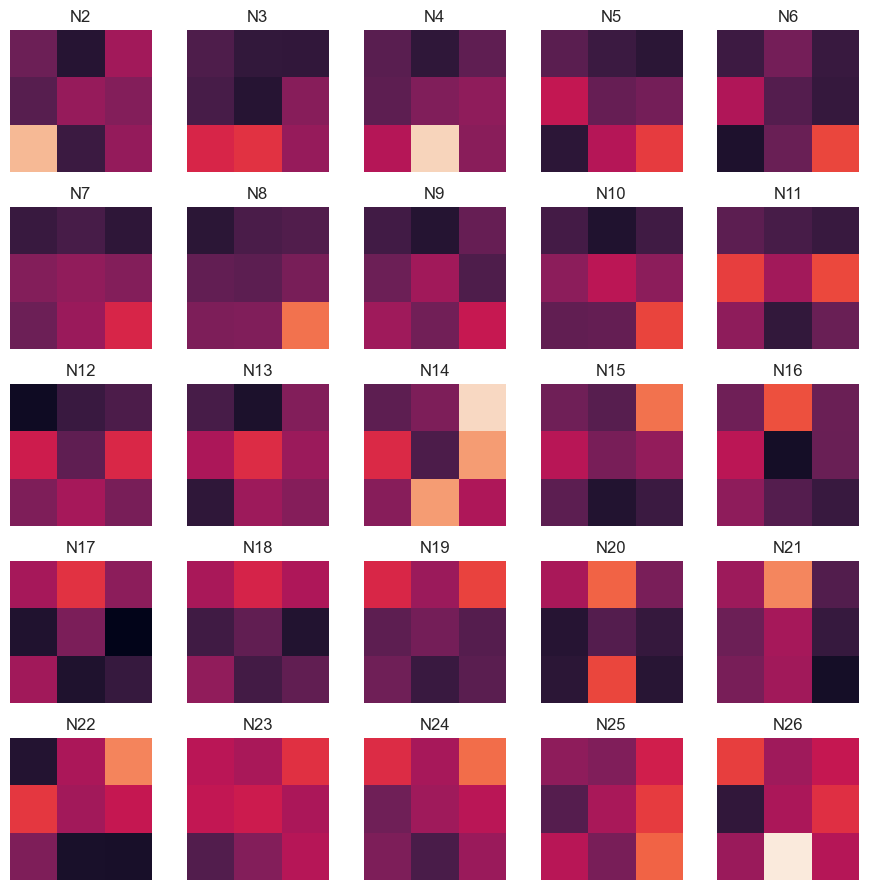

In [100]:
n_heads = [ca.rule.readouts[i].weight.data.abs().sum(dim=0) for i in range(len(Ns))]
# n_heads = [ca.rule.readouts[i].weight.data[1] for i in range(len(Ns))]
n_heads = [mat.reshape(READOUT_CHANNELS, ca.rule.readout_res, ca.rule.readout_res).cpu().mean(dim=0) for mat in n_heads]
n_heads = torch.stack(n_heads).numpy()

fig, axes = plt.subplots(int(np.sqrt(len(n_heads))), int(np.sqrt(len(n_heads))), figsize=(9, 9))
axes = axes.flatten()

vmin = n_heads.min()
vmax = n_heads.max()
for i, ax in enumerate(axes):
    n_head = n_heads[i]
    im = ax.imshow(n_head, vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'N{i + 2}')
    # if i == 0:
    #     plt.colorbar(im, ax=ax, fraction=0.04)
        
plt.tight_layout()

(-0.5, 2.5, 2.5, -0.5)

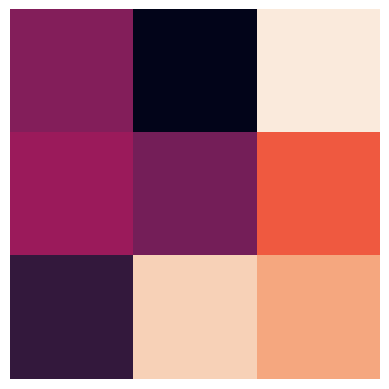

In [101]:
plt.imshow(np.mean(n_heads, axis=0)); plt.axis('off')

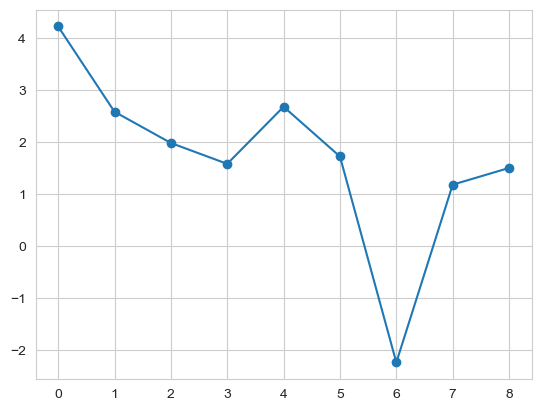

In [102]:
plt.plot(ca.rule.alpha.detach().cpu().numpy(), 'o-')

In [103]:
filters = [ca.rule.filters[i].data for i in range(len(ca.rule.filters))]
filters = [mat.reshape(3, 3).cpu() for mat in filters]
filters = torch.stack(filters).numpy()

# fig, axes = plt.subplots(int(np.sqrt(len(filters))), int(np.sqrt(len(filters))), figsize=(7, 7))
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
axes = axes.flatten()

vmin = filters.min()
vmax = filters.max()
for i, ax in enumerate(axes):
    filter = filters[i]
    im = ax.imshow(filter, vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'N{i + 2}')
    plt.colorbar(im, ax=ax, fraction=0.04)

RuntimeError: stack expects a non-empty TensorList

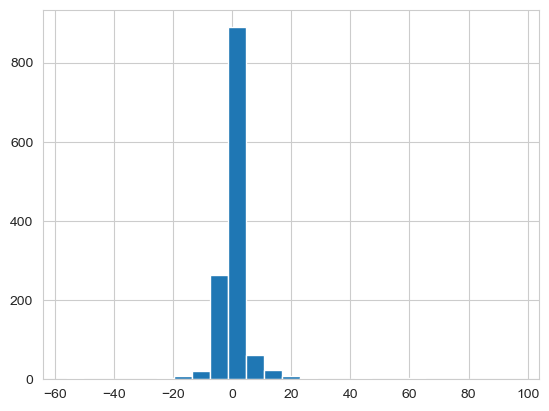

In [104]:
plt.hist(state.reshape(-1).cpu().numpy(), 25); # plt.yscale('log')